# Setup for raw approach

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
df = pd.read_csv("./dataset_1.csv")


### Removing null values and scaling features
Features are scaled for each non-target attribute in teh dataframe.
Values are scaled to be strictly between -1 and 1.

In [3]:

non_t = [i for i in df.columns if i!="target"]
for EPOCH in non_t:
    if df[EPOCH].max()!=df[EPOCH].min():
        df[EPOCH] = (df[EPOCH]-df[EPOCH].min())/abs(df[EPOCH].max()-df[EPOCH].min())
    else:
        df[EPOCH] = df[EPOCH]/df[EPOCH].max() if df[EPOCH].max()!=0 else df[EPOCH]
    df[EPOCH].fillna(df[EPOCH].mode())


---

### Vectorized functions used later (includes activation function and out of bound value handlers)

```handler(x)``` uses a hardcoded bound, because for values too large or small, np.exp reaches too many decimal places and cannot handle the number of digits, resulting in a NaN value.

$$ logit(x) = sigmoid^{-1}(x) = \ln{\left(\frac{x}{1-x}\right)}\newline sigmoid(bound)\approx x $$

In [4]:
HANDLER_BOUND = 25

def handler(x):
    x = x.copy()
    x[x>HANDLER_BOUND] = HANDLER_BOUND
    x[x<-HANDLER_BOUND] = -HANDLER_BOUND
    return x

logit = lambda x:np.log(x/(1-x))
print(logit(0.999999999986),1/(1+np.exp(-HANDLER_BOUND)))


24.991962117527418 0.999999999986112


In [5]:
sig = lambda x:1/(1+np.exp(-x))
sig=np.vectorize(sig)

def sigmoid(x):
    x = handler(x)
    return sig(x)

def tan_h(x):
    x = handler(x)
    return np.tanh(x)

def ex(x):
    x = handler(x)
    return np.exp(-x)


### Dataset and training variables

In [6]:
n = df.shape[1]-1
m = df.shape[0]
LEARNING_RATE = 0.25
EPOCHS = 100
W = np.random.random(n)
b = np.random.random(n)
X = np.array(df.drop("target",axis=1)).T
Y = np.array(df["target"])


In [7]:
print(f"Number of attributes: {n}")
print(f"Training size: {m}")
print(f"Shape of train set: {X.shape}")
print(f"Shape of hidden layer weights and biases: {W.shape}")


Number of attributes: 300
Training size: 50000
Shape of train set: (300, 50000)
Shape of hidden layer weights and biases: (300,)


---

# Non-pytorch "Raw" approach

### Logistic regression

0.1991362249274998


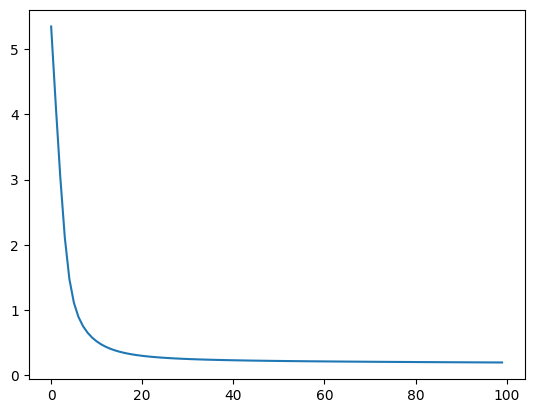

In [8]:
W = np.random.random(n)
b = 0
j_s,i_s = [],[]
for EPOCH in range(EPOCHS):
    Z = np.dot(W.T,X)+b
    A = sigmoid(Z)
    L = -(np.dot(Y,np.log(A))+np.dot((1-Y),np.log((1-A))))
    J = np.sum(L)/m
    j_s.append(J)
    i_s.append(EPOCH)

    dZ = A-Y
    dW = np.dot(X,dZ.T)/m
    db = dZ/m
    W,b=W-LEARNING_RATE*dW,b-LEARNING_RATE*db

sns.lineplot(x=i_s,y=j_s)
print(J)


---

### 2-Layered Logistic regression based neural network

0.17356593695494288


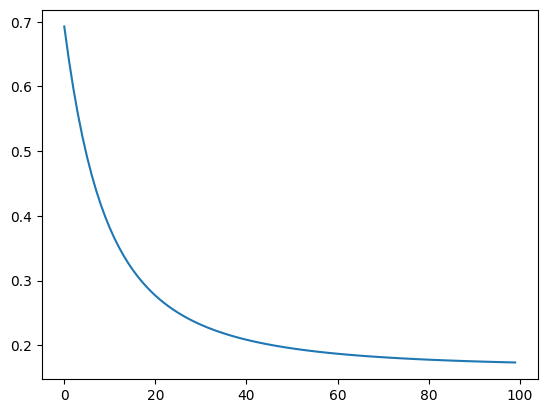

In [9]:
A0 = X
W1 = np.array([np.random.normal(loc=0.0, scale=1.0) * 0.01 for _ in range(4*n)]).reshape((4,n))
b1 = 0
W2 = np.array([np.random.normal(loc=0.0, scale=1.0) * 0.01 for _ in range(4)])
b2=0
Z1 = np.dot(W1,A0)+b1
A1 = tan_h(Z1)
Z2 = np.dot(W2.T,A1)+b2
A2 = sigmoid(Z2)
L = -(np.dot(Y,np.log(A2))+np.dot((1-Y),np.log((1-A2))))
J = np.sum(L)/m
j_s,i_s = [],[]

for EPOCH in range(EPOCHS):
    Z1 = np.dot(W1,A0)+b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2.T,A1)+b2
    A2 = sigmoid(Z2)
    L = -(np.dot(Y,np.log(A2))+np.dot((1-Y),np.log((1-A2))))
    J = np.sum(L)/m
    j_s.append(J)
    i_s.append(EPOCH)

    dZ2 = (A2-Y)/m
    dW2 = np.dot(A1,dZ2)
    db2=np.sum(dZ2)
    dW1 = np.dot(A0,np.dot((ex(Z1)*A1*A1).T,np.matmul(A1,dZ2)))
    db1 = np.dot((ex(Z1)*A1*A1).T,np.matmul(A1,dZ2)).sum()

    W2-=LEARNING_RATE*dW2
    b2-=LEARNING_RATE*db2
    W1-=LEARNING_RATE*dW1
    b1-=LEARNING_RATE*db1

sns.lineplot(x=i_s,y=j_s)
print(J)


# PyTorch approach

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import torch                                      # root package
from torch.utils.data import Dataset, DataLoader  # dataset representation and loading
import torch.autograd as autograd                 # computation graph
from torch import Tensor                          # tensor node in the computation graph
import torch.nn as nn                             # neural networks
import torch.nn.functional as F                   # layers, activations and more
import torch.optim as optim                       # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace               # hybrid frontend decorator and tracing jit


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [12]:
df = pd.read_csv("./dataset_1.csv")


non_t = [i for i in df.columns if i!="target"]
for EPOCH in non_t:
    if df[EPOCH].max()!=df[EPOCH].min():
        df[EPOCH] = (df[EPOCH]-df[EPOCH].min())/abs(df[EPOCH].max()-df[EPOCH].min())
    else:
        df[EPOCH] = df[EPOCH]/df[EPOCH].max() if df[EPOCH].max()!=0 else df[EPOCH]
    df[EPOCH].fillna(df[EPOCH].mode())


In [13]:

N = df.shape[1]-1
LEARNING_RATE = 0.25
EPOCHS = 1000
FRAC_TRAIN = 0.8
X = np.array(df.drop("target",axis=1)).T
Y = np.array(df["target"])
X = torch.tensor(X,dtype=torch.float32,device=device).permute((1,0))
y = torch.tensor(Y,dtype=torch.float32,device=device).unsqueeze(dim=1)
# X_train,y_train = X[:int(FRAC_TRAIN*len(X))],y[:int(FRAC_TRAIN*len(y))]
# X_test,y_test = X[int(FRAC_TRAIN*len(X)):],y[int(FRAC_TRAIN*len(y)):]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1-FRAC_TRAIN,random_state=44)

print(len(X_train),len(y_train))
print(len(X_test),len(y_test))


40000 40000
10000 10000


In [14]:
class BinaryClassifier_0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=N,
                                 out_features=4)
        self.layer_2 = nn.Linear(in_features=4,
                                 out_features=1)
        self.layer_3 = nn.Sigmoid()

    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))

activation = nn.ReLU()

torch.manual_seed(42)
model_0 = BinaryClassifier_0().to(device)

torch.manual_seed(42)
model_1 = nn.Sequential(
    nn.Linear(in_features=N,
              out_features=32),
    activation,
    nn.Linear(in_features=32,
              out_features=4),
    activation,
    nn.Linear(in_features=4,
                out_features=1)
).to(device)

loss_fn = nn.BCEWithLogitsLoss().to(device) #has sigmoid built-in, the other Sigmoid is just a layer
optimizer_0 = optim.SGD(params=model_0.parameters(),
                      lr=LEARNING_RATE)
optimizer_1 = optim.SGD(params=model_1.parameters(),
                      lr=LEARNING_RATE)


Final training loss: 0.6933
Final testing loss: 0.6933


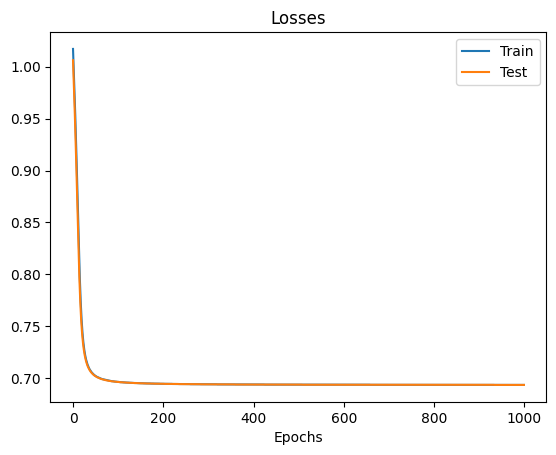

In [15]:
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model_0.train()
    y_pred_train = model_0(X_train)
    loss_train = loss_fn(y_pred_train,y_train)
    optimizer_0.zero_grad()
    loss_train.backward()
    optimizer_0.step()

    model_0.eval()
    with torch.inference_mode():
        y_pred_test = model_0(X_test) #gives logits
        loss_test = loss_fn(y_pred_test,y_test)

    train_losses.append(eval(f"{loss_train:.4f}"))
    test_losses.append(eval(f"{loss_test:.4f}"))

print(f"Final training loss: {loss_train:.4f}")
print(f"Final testing loss: {loss_test:.4f}")

plt.plot(train_losses,label="Train")
plt.plot(test_losses,label="Test")
plt.legend()
plt.title("Losses")
plt.xlabel("Epochs")
plt.show()


Final training loss: 0.1691
Final testing loss: 0.1607


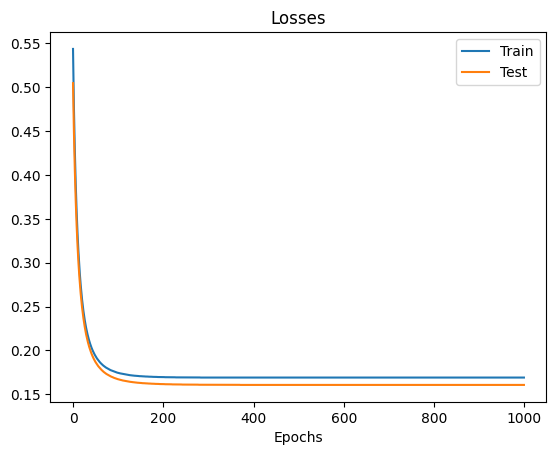

In [16]:
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model_1.train()
    y_pred_train = model_1(X_train)
    loss_train = loss_fn(y_pred_train,y_train)
    optimizer_1.zero_grad()
    loss_train.backward()
    optimizer_1.step()

    model_1.eval()
    with torch.inference_mode():
        y_pred_test = model_1(X_test)
        loss_test = loss_fn(y_pred_test,y_test)

    train_losses.append(eval(f"{loss_train:.4f}"))
    test_losses.append(eval(f"{loss_test:.4f}"))

print(f"Final training loss: {loss_train:.4f}")
print(f"Final testing loss: {loss_test:.4f}")

plt.plot(train_losses,label="Train")
plt.plot(test_losses,label="Test")
plt.legend()
plt.title("Losses")
plt.xlabel("Epochs")
plt.show()
